In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.fft import irfft, rfft, rfftfreq
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from scipy.signal import welch
import os

from helper_funcs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load dataframe(s) and concatenate (with laptop=False and no dfs_to_load this loads all dataframes with OSC paths)
laptop = True
dfs_to_load = ["York Data 1"]
df = load_df(laptop=laptop, dfs_to_load=dfs_to_load)

Loading York Data 1
Combining into one Dataframe!


In [7]:
# Restrict to just waveform rows
df = df[df['wf'].notna()]

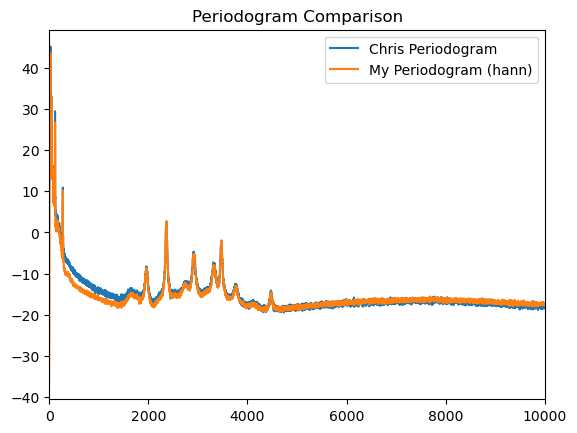

In [83]:
# Get frequency axis
f = rfftfreq(32768, 1/44100)

index = 10
wf = df.iloc[index]['wf']

win_type='hann'

chris_pg = get_periodogram_og_chris(wf, rms_factor=False)
my_pg = get_welch(wf, win_type=win_type)
scipy_pg = get_scipy_welch(wf, win_type=win_type)
plt.plot(f, chris_pg, label='Chris Periodogram')
plt.plot(f, my_pg, label=f'My Periodogram ({win_type})')
# plt.plot(f, scipy_pg, label='Scipy Periodogram', alpha=0.5)
plt.xlim(0, 10000)
# plt.ylim(-10, 10)
plt.title("Periodogram Comparison")
plt.legend()
plt.show()

# print(my_pg)
# print(scipy_pg)

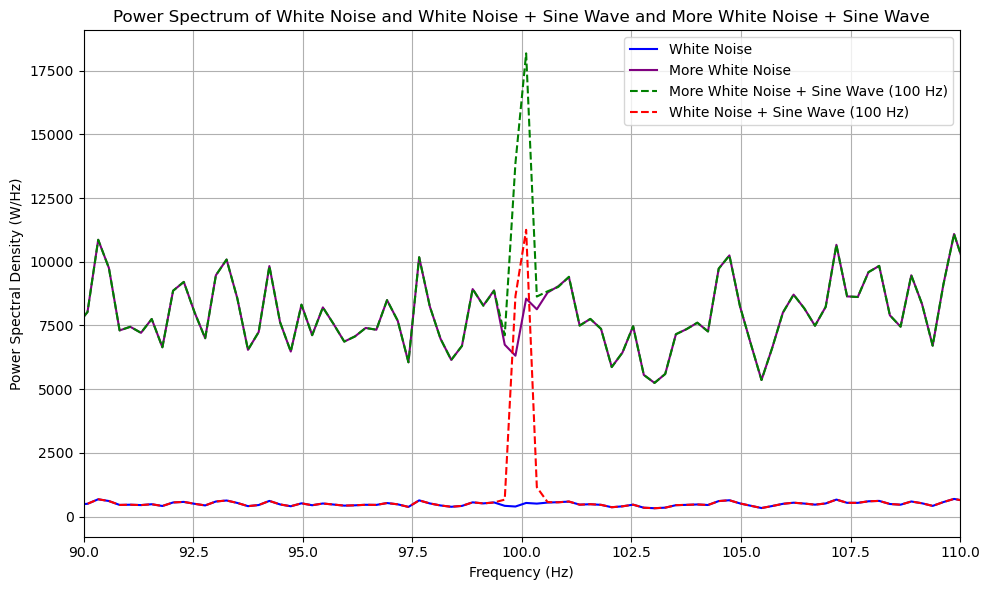

Power Spectrum at 100 Hz for White Noise: 534.584042 W/Hz
Power Spectrum at 100 Hz for White Noise + Sine Wave: 11253.870019 W/Hz
Power Spectrum at 100 Hz for Sine Wave: 11083.400943 W/Hz
Difference in Power Spectrum at 100 Hz (White Noise + Sine Wave - White Noise): 10719.285977 W/Hz


In [74]:
"Exploring noise and signal addition"

# Parameters
fs = 1000  # Sampling frequency (Hz)
duration = 100  # Duration of the signal (seconds)
n_samples = fs * duration  # Total number of samples
f_sine = 100  # Frequency of the sine wave (Hz)
noise_amp = 500
more_noise_amp = 2000
sine_amp = 100
window = 'hann'

# Generate white noise
base_noise = np.random.normal(0, 1, n_samples)
white_noise = noise_amp * base_noise
more_white_noise = more_noise_amp * base_noise

# Generate a sine wave at 100 Hz
t = np.arange(n_samples) / fs  # Time vector
sine_wave = sine_amp * np.sin(2 * np.pi * f_sine * t)

# Add the sine wave to the white noise
signal_with_sine = white_noise + sine_wave
more_white_noise_with_sine = more_white_noise + sine_wave

# Compute the Power Spectral Density (PSD) of the white noise
f_white_noise, Pxx_white_noise = welch(white_noise, fs, window=window, nperseg=4096)

# Compute the Power Spectral Density (PSD) of the more white noise
f_more_white_noise, Pxx_more_white_noise = welch(more_white_noise, fs, window=window, nperseg=4096)

# Compute the Power Spectral Density (PSD) of the signal with the sine wave
f_signal, Pxx_signal = welch(signal_with_sine, fs, window=window, nperseg=4096)

# Compute the Power Spectral Density (PSD) of the signal with the sine wave
f_signal_more_noise, Pxx_signal_more_noise = welch(more_white_noise_with_sine, fs, window=window, nperseg=4096)

# Compute the Power Spectral Density (PSD) of the sine wave
f_sine_wave, Pxx_sine_wave = welch(sine_wave, fs, window=window, nperseg=4096)

# Plot both power spectra (White Noise and White Noise + Sine Wave) on the same plot
plt.figure(figsize=(10, 6))

plt.plot(f_white_noise, Pxx_white_noise, label='White Noise', color='b')
plt.plot(f_more_white_noise, Pxx_more_white_noise, label='More White Noise', color='purple')
plt.plot(f_signal_more_noise, Pxx_signal_more_noise, label='More White Noise + Sine Wave (100 Hz)', color='g', linestyle='--')
plt.plot(f_signal, Pxx_signal, label='White Noise + Sine Wave (100 Hz)', color='r', linestyle='--')

plt.title('Power Spectrum of White Noise and White Noise + Sine Wave and More White Noise + Sine Wave')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (W/Hz)')
plt.xlim(90, 110)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# # Plot the power spectrum of just the sine wave
# plt.figure(figsize=(10, 6))
# plt.plot(f_sine_wave, Pxx_sine_wave, label='Sine Wave at 100 Hz', color='g')
# plt.title('Power Spectrum of Sine Wave at 100 Hz')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power Spectral Density (W/Hz)')
# plt.xlim(90, 110)
# plt.legend()
# plt.grid()

# plt.tight_layout()
# plt.show()

# Find the index closest to 100 Hz in the frequency arrays
index_100Hz_signal = np.argmin(np.abs(f_signal - f_sine))
index_100Hz_white_noise = np.argmin(np.abs(f_white_noise - f_sine))
index_100Hz_sine_wave = np.argmin(np.abs(f_sine_wave - f_sine))

# Get the power spectral densities at 100 Hz for both signals
Pxx_white_noise_100Hz = Pxx_white_noise[index_100Hz_white_noise]
Pxx_signal_100Hz = Pxx_signal[index_100Hz_signal]
Pxx_sine_wave_100Hz = Pxx_sine_wave[index_100Hz_sine_wave]

# Compute the difference between the two spectra at 100 Hz
difference_at_100Hz = Pxx_signal_100Hz - Pxx_white_noise_100Hz

# Print the power at {f_sine} Hz for each spectrum and the difference
print(f"Power Spectrum at {f_sine} Hz for White Noise: {Pxx_white_noise_100Hz:.6f} W/Hz")
print(f"Power Spectrum at {f_sine} Hz for White Noise + Sine Wave: {Pxx_signal_100Hz:.6f} W/Hz")
print(f"Power Spectrum at {f_sine} Hz for Sine Wave: {Pxx_sine_wave_100Hz:.6f} W/Hz")
print(f"Difference in Power Spectrum at 100 Hz (White Noise + Sine Wave - White Noise): {difference_at_100Hz:.6f} W/Hz")

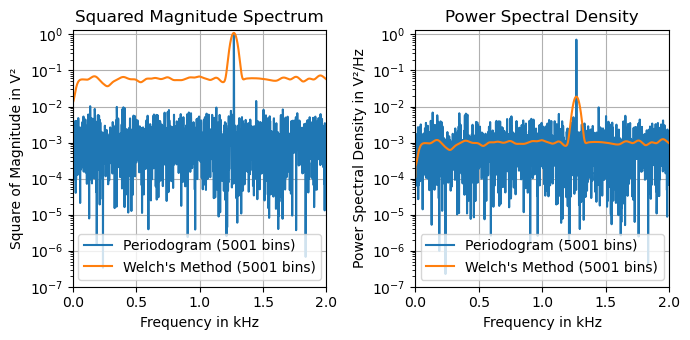

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

rng = np.random.default_rng(73625)  # seeding for reproducibility

fs, n = 10e3, 10_000
f_x, noise_power = 1270, 1e-3 * fs / 2
t = np.arange(n) / fs
x = (np.sqrt(2) * np.sin(2 * np.pi * f_x * t) +
     rng.normal(scale=np.sqrt(noise_power), size=t.shape))

fg, axx = plt.subplots(1, 2, sharex='all', tight_layout=True, figsize=(7, 3.5))
axx[0].set(title="Squared Magnitude Spectrum", ylabel="Square of Magnitude in V²")
axx[1].set(title="Power Spectral Density", ylabel="Power Spectral Density in V²/Hz")
for ax_, s_ in zip(axx, ('spectrum', 'density')):
    f_p, P_p = signal.periodogram(x, fs, 'hann', scaling=s_)
    f_w, P_w = signal.welch(x, fs, scaling=s_, nfft=int(len(x)))
    ax_.semilogy(f_p/1e3, P_p, label=f"Periodogram ({len(f_p)} bins)")
    ax_.semilogy(f_w/1e3, P_w, label=f"Welch's Method ({len(f_w)} bins)")
    ax_.set(xlabel="Frequency in kHz", xlim=(0, 2), ylim=(1e-7, 1.3))
    ax_.grid(True)
    ax_.legend(loc='lower center')
plt.show()